<a href="https://colab.research.google.com/github/samridhi20-hub/Deep-Learning_a1901641/blob/main/Samridhi_Gupta_DL_A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. All Imports

In [ ]:
# All imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, LSTM, Bidirectional, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Load the train dataset
train_data = pd.read_csv('/content/Google_Stock_Price_Train.csv')
# Display basic info to confirm loading
print("Training Dataset:")
print(train_data.info())
print(train_data.head())

Training Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB
None
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800


In [ ]:
# Load the test dataset
test_data = pd.read_csv('/content/Google_Stock_Price_Test.csv')
# Display basic info to confirm loading
print("Test Dataset:")
print(test_data.info())
print(test_data.head())

Test Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB
None
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


# 2. Pre-processing the data


In [ ]:
# Pre-processing and preparing the dataset for modelling
# Features to include in the model (leaving out the date column for now)
features = ['Open', 'Close', 'High', 'Low', 'Volume']

# Clean and convert columns to numeric
for col in features:
    train_data[col] = pd.to_numeric(train_data[col].astype(str).str.replace(',', ''), errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col].astype(str).str.replace(',', ''), errors='coerce')

# Drop rows with missing values
train_data = train_data.dropna()
test_data = test_data.dropna()

# Extract features and target
train_features = train_data[features]
test_features = test_data[features]
train_target = train_data['Open']  # Using 'Open' as the target
test_target = test_data['Open']

# Initialize separate scalers for features and target
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit scalers
train_features_scaled = scaler_features.fit_transform(train_features)
test_features_scaled = scaler_features.transform(test_features)

train_target_scaled = scaler_target.fit_transform(train_target.values.reshape(-1, 1))
test_target_scaled = scaler_target.transform(test_target.values.reshape(-1, 1))

# Create sequences for RNN
def create_sequences_multi(data, target, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, :])  # Use all columns for input
        y.append(target[i])              # Use target column for output
    return np.array(X), np.array(y)

timesteps = 10  # Number of time steps per sequence
# Using less number of timesteps because the dataset is not very huge

# Generate train and test sequences
X_train_seq, y_train_seq = create_sequences_multi(train_features_scaled, train_target_scaled, timesteps)
X_test_seq, y_test_seq = create_sequences_multi(test_features_scaled, test_target_scaled, timesteps)

# Reshape for RNN input
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], len(features)))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], len(features)))

# Verify shapes
print("Shape of X_train_seq:", X_train_seq.shape)  # (samples, timesteps, features)
print("Shape of y_train_seq:", y_train_seq.shape)  # (samples,)
print("Shape of X_test_seq:", X_test_seq.shape)    # (samples, timesteps, features)
print("Shape of y_test_seq:", y_test_seq.shape)    # (samples,)


Shape of X_train_seq: (1248, 10, 5)
Shape of y_train_seq: (1248, 1)
Shape of X_test_seq: (10, 10, 5)
Shape of y_test_seq: (10, 1)


# 3. Splitting train dataset

In [ ]:
# Splitting train data further into train and validation sets
X_train_seq, X_val_seq, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, y_train_seq, test_size=0.2, random_state=56)

# 4. Vanilla RNN

In [ ]:
# RNN model architecture
# Create a simple Vanilla RNN model with an RNN layer followed by a Dense output layer
# Define the RNN model
model = Sequential()

# Add the RNN layer
model.add(SimpleRNN(units=50, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the Dense output layer (regression output for stock price prediction)
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 50)                  │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - loss: 0.0762 - val_loss: 0.0021
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0196 - val_loss: 0.0018
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0104 - val_loss: 0.0012
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 8.0861e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0056 - val_loss: 0.0029
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0054 - val_loss: 9.5908e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0054 - val_loss: 5.0412e-04
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0042 - val_loss: 0.0011
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 7.2127e-04
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0034 - val_loss: 4.1040e-04
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0031 - val_loss: 6.2284e-04
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0

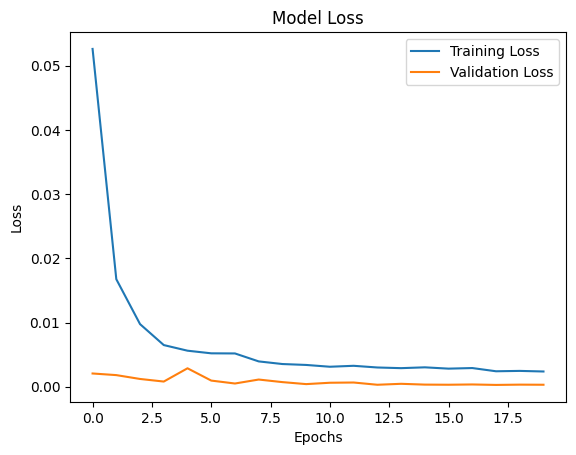

In [ ]:
# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_data=(X_val_seq, y_val_seq))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - loss: 9.8032e-04
Test Loss: 0.0009803210850805044


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


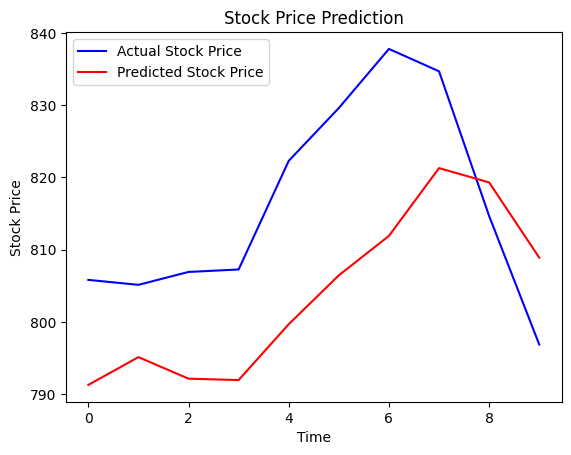

In [ ]:
# Make predictions using the trained model
predicted_stock_price = model.predict(X_test_seq)
predicted_stock_price_og = scaler_target.inverse_transform(predicted_stock_price)
# tranforming back to compare at original scale
y_test_original = scaler_target.inverse_transform(y_test_seq)

# Plot the predicted vs actual stock prices
plt.plot(y_test_original, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_og, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_original, predicted_stock_price_og)
rmse = np.sqrt(mean_squared_error(y_test_original, predicted_stock_price_og))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 15.650035644531238, RMSE: 16.831060056201473


Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0038 - val_loss: 5.5694e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_loss: 7.5427e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 3.1890e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - val_loss: 3.9799e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 6.6949e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 3.8395e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 2.1068e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - val_loss: 2.3879e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - val_loss: 1.6694e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - val_loss: 2.3061e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 5.0803e-04
Epoch 12/50
63/63 ━━━━━━━━━━━━

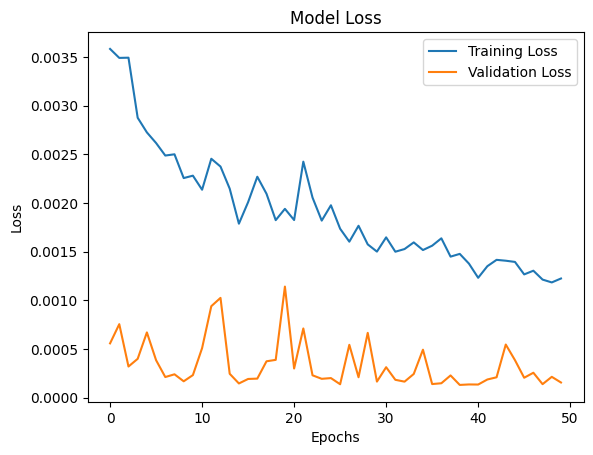

In [ ]:
# Increasing the epochs to 50
# changing the batch size to 16
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_data=(X_val_seq, y_val_seq))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 3.8312e-04
Test Loss: 0.00038312317337840796


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


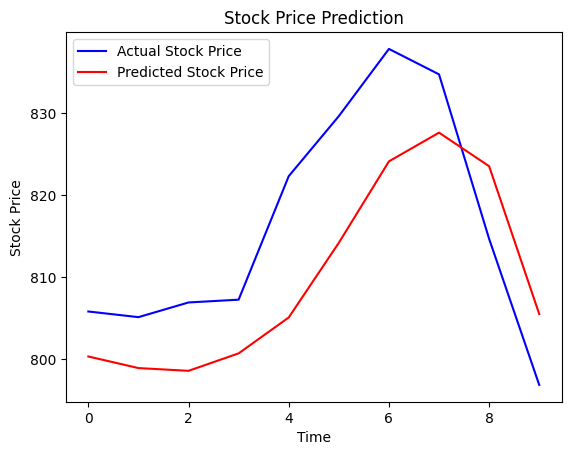

In [ ]:
# Make predictions using the trained model
predicted_stock_price = model.predict(X_test_seq)
predicted_stock_price_og = scaler_target.inverse_transform(predicted_stock_price)
# tranforming back to compare at original scale
y_test_original = scaler_target.inverse_transform(y_test_seq)

# Plot the predicted vs actual stock prices
plt.plot(y_test_original, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_og, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_original, predicted_stock_price_og)
rmse = np.sqrt(mean_squared_error(y_test_original, predicted_stock_price_og))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 9.752916503906238, RMSE: 10.521962030715983


# 4a. Implementing early stoppping

In [ ]:
# Using EarlyStopping to monitor performance
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping]
)
# The patience=5 ensures that training stops if the validation loss doesn't improve for 5 consecutive epochs

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 1.2894e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 1.7077e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 3.3530e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 1.5519e-04
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6080e-04 - val_loss: 1.3802e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 2.3221e-04


In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print(f"Test Loss (MSE): {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.2829e-04
Test Loss (MSE): 0.0003282870166003704


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


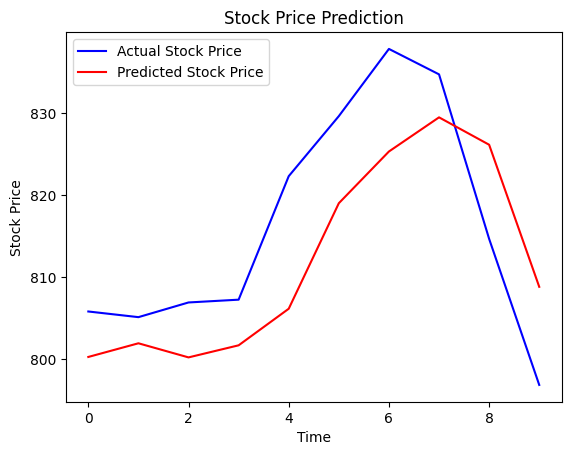

In [ ]:
# Make predictions using the trained model
predicted_stock_price = model.predict(X_test_seq)
predicted_stock_price_og = scaler_target.inverse_transform(predicted_stock_price)
# tranforming back to compare at original scale
y_test_original = scaler_target.inverse_transform(y_test_seq)

# Plot the predicted vs actual stock prices
plt.plot(y_test_original, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_og, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_original, predicted_stock_price_og)
rmse = np.sqrt(mean_squared_error(y_test_original, predicted_stock_price_og))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 8.892705322265613, RMSE: 9.739896365004503


# 5. Adding regularization to the RNN base model

In [ ]:
from keras.regularizers import l2
# Define the RNN model
model = Sequential()

# Add the RNN layer with L2 kernel regularization
model.add(SimpleRNN(
    units=50,
    return_sequences=False,
    input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
    kernel_regularizer=l2(0.01)  # L2 regularization
))

# Add Dropout to prevent overfitting
model.add(Dropout(0.2))

# Add the Dense output layer with L2 kernel regularization
model.add(Dense(
    units=1,
    kernel_regularizer=l2(0.01)  # L2 regularization
))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 50)                  │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model for a fixed number of epochs
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,  # Fixed number of epochs
    batch_size=32,  # You can adjust this as needed
    validation_data=(X_val_seq, y_val_seq)  # Validation data to monitor performance
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_lo

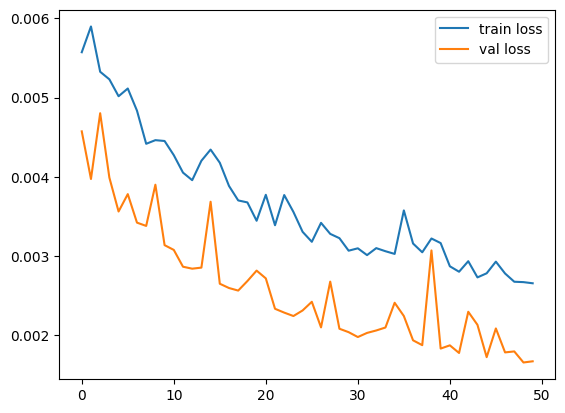

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 9.5606e-04
Test Loss: 0.0009560574544593692


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


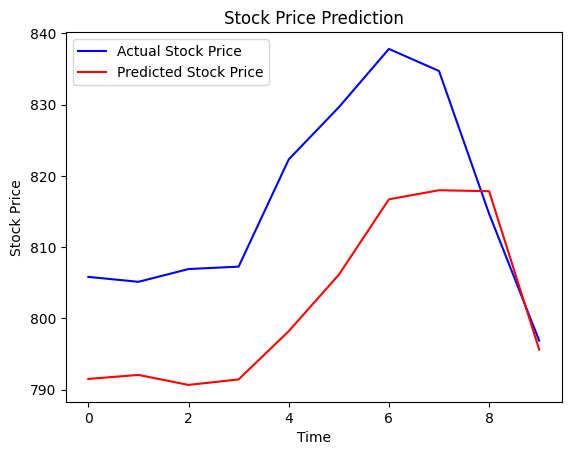

In [ ]:
# Make predictions using the trained model
predicted_stock_price = model.predict(X_test_seq)
predicted_stock_price_og = scaler_target.inverse_transform(predicted_stock_price)
# tranforming back to compare at original scale
y_test_original = scaler_target.inverse_transform(y_test_seq)

# Plot the predicted vs actual stock prices
plt.plot(y_test_original, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_price_og, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
mae = mean_absolute_error(y_test_original, predicted_stock_price_og)
rmse = np.sqrt(mean_squared_error(y_test_original, predicted_stock_price_og))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 14.93940624999999, RMSE: 16.621457173024158


# 6. LSTM model

In [ ]:
# Define the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    # Add LSTM layer
    model.add(LSTM(units=50, activation='tanh', return_sequences=False, input_shape=input_shape))
    # Output layer
    model.add(Dense(units=1))
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
lstm_model = build_lstm_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# Summary of the model
lstm_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1682 - val_loss: 0.0402
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5531e-04 - val_loss: 0.0012
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0304e-04 - val_loss: 0.0011
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7600e-04 - val_loss: 7.7457e-04
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5880e-04 - val_loss: 0.0011
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010 - val_loss: 7.9036e-04
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0502e-04 - val_loss: 0.0016
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6566e-04 - val_loss: 0.0012
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4543e-04 - val_loss: 0.0010
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━

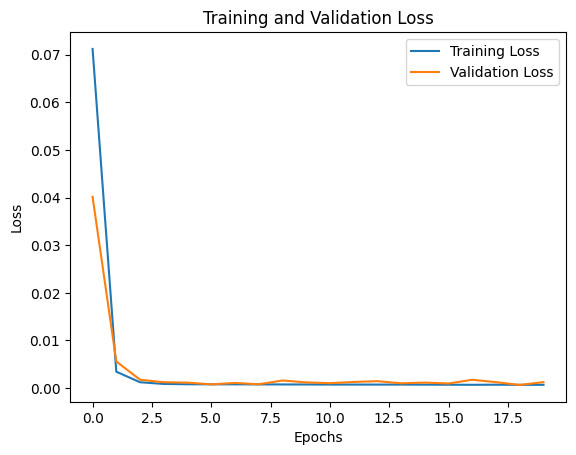

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.8032e-04
Test Loss: 0.0009803210850805044


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test data
y_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual_inv, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_inv))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
MAE: 16.138035400390606
RMSE: 18.931608078641915


# 7. Experimenting with more number of epochs and a different batch size

In [ ]:
# increasing the epochs to 30
# Train the LSTM model
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1162e-04 - val_loss: 0.0016
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6364e-04 - val_loss: 9.3601e-04
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4076e-04 - val_loss: 0.0011
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7715e-04 - val_loss: 0.0011
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8943e-04 - val_loss: 6.8149e-04
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9160e-04 - val_loss: 9.3367e-04
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0462e-04 - val_loss: 8.1375e-04
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0140e-04 - val_loss: 0.0011
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7804e-04 - val_loss: 7.5584e-04
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9305e-04 - val_loss: 7.4104e-04
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4079e-04 - val_loss: 9.4698e-04
Ep

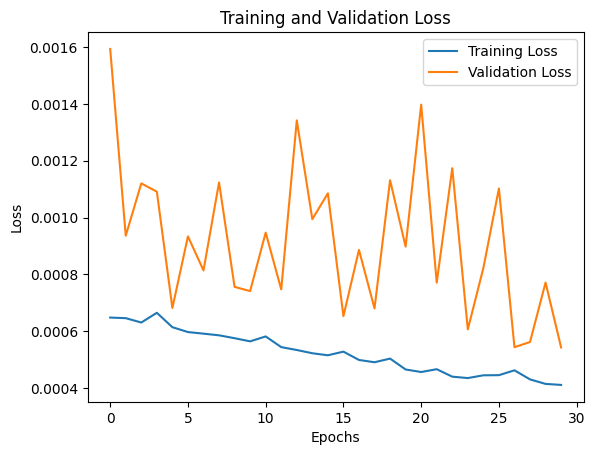

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.8032e-04
Test Loss: 0.0009803210850805044


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on test data
y_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual_inv, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_inv))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
MAE: 10.203874023437503
RMSE: 12.520586425660461


In [ ]:
# Increasing the epochs to 40
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=40,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1)

Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7233e-04 - val_loss: 4.0966e-04
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6093e-04 - val_loss: 5.4332e-04
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7165e-04 - val_loss: 4.3996e-04
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1425e-04 - val_loss: 4.0634e-04
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8014e-04 - val_loss: 4.8404e-04
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1095e-04 - val_loss: 5.4494e-04
Epoch 7/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4556e-04 - val_loss: 3.8288e-04
Epoch 8/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8091e-04 - val_loss: 5.6667e-04
Epoch 9/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1279e-04 - val_loss: 5.2345e-04
Epoch 10/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9323e-04 - val_loss: 4.2652e-04
Epoch 11/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0107e-04 - val_los

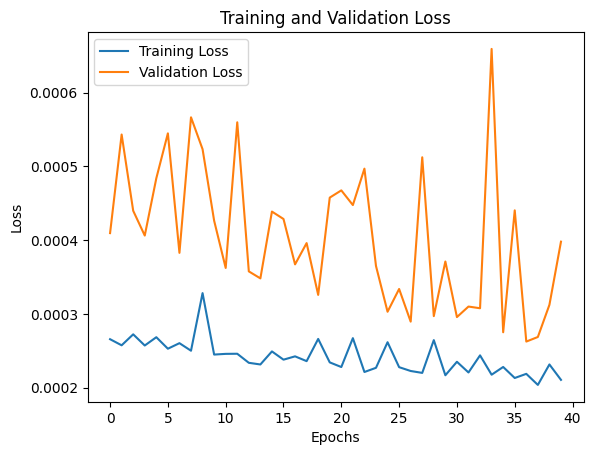

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss = model.evaluate(X_test_seq, y_test_seq)
print(f'Test Loss: {test_loss}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.8032e-04
Test Loss: 0.0009803210850805044


In [ ]:
# Predict on test data
y_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual_inv, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_inv))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
MAE: 8.200033203124997
RMSE: 10.725044737056317


In [ ]:
# increasing epochs to 50
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1093e-04 - val_loss: 5.6246e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3361e-04 - val_loss: 3.1321e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3894e-04 - val_loss: 6.7520e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1031e-04 - val_loss: 3.1845e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3433e-04 - val_loss: 3.0184e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0424e-04 - val_loss: 4.2546e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.7627e-04 - val_loss: 5.8426e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4850e-04 - val_loss: 3.5938e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0706e-04 - val_loss: 3.0916e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5807e-04 - val_loss: 2.8304e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8986e-04 - val_los

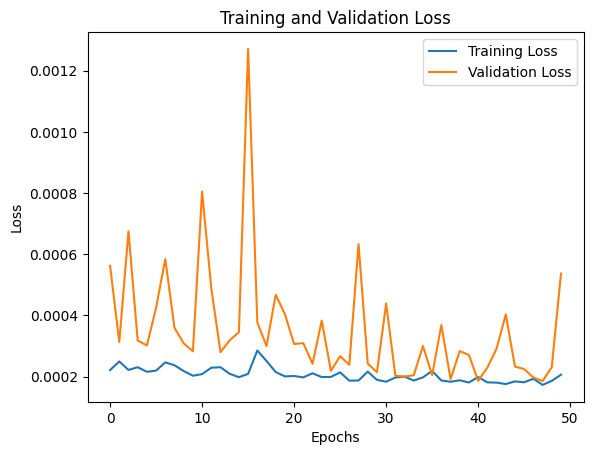

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual_inv, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_inv))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
MAE: 11.152916503906237
RMSE: 12.454449301791382


In [ ]:
# now, testing the LSTM model with 80 epochs
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=80,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1624e-04 - val_loss: 1.9636e-04
Epoch 2/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8074e-04 - val_loss: 3.5647e-04
Epoch 3/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8309e-04 - val_loss: 1.7280e-04
Epoch 4/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6858e-04 - val_loss: 2.9891e-04
Epoch 5/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1062e-04 - val_loss: 2.4198e-04
Epoch 6/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.6064e-04 - val_loss: 1.7525e-04
Epoch 7/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.4082e-04 - val_loss: 4.0003e-04
Epoch 8/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5548e-04 - val_loss: 2.0548e-04
Epoch 9/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3848e-04 - val_loss: 1.6502e-04
Epoch 10/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8080e-04 - val_loss: 2.0575e-04
Epoch 11/80
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0984e-04 - val_l

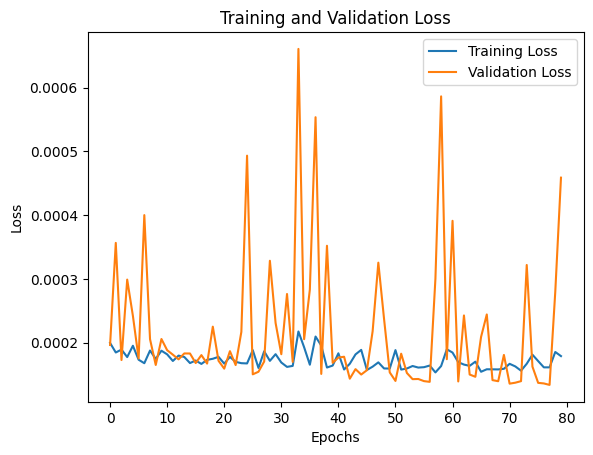

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred = lstm_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_inv = scaler_target.inverse_transform(y_test_pred)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_actual_inv, y_test_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_inv))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
MAE: 10.58491406249999
RMSE: 11.513947821527426


# 8. Adding L2 regularization to LSTM

In [ ]:
# Modifying the LSTM model by adding L2 regularization
from tensorflow.keras.regularizers import l2

# Define the LSTM model with regularization
def build_lstm_model_with_regularization(input_shape):
    model = Sequential()

    # Add LSTM layer with regularization
    model.add(LSTM(
        units=50,
        activation='tanh',
        return_sequences=False,
        input_shape=input_shape,
        recurrent_dropout=0.2,  # Recurrent dropout for recurrent connections
        kernel_regularizer=l2(0.01)  # L2 regularization on weights
    ))

    # Add Dropout layer
    model.add(Dropout(0.3))  # 30% dropout rate

    # Output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build the model
lstm_model_reg = build_lstm_model_with_regularization(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# Summary of the model
lstm_model_reg.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the LSTM model with regularization and changing the batch size to 16
history_reg = lstm_model_reg.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0061 - val_loss: 0.0032
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0057 - val_loss: 0.0021
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0042 - val_loss: 0.0021
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0043 - val_loss: 0.0019
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0037 - val_loss: 0.0076
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

In [ ]:
# Predict on test data
y_test_pred_reg = lstm_model_reg.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_reg_inv = scaler_target.inverse_transform(y_test_pred_reg)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_reg = mean_absolute_error(y_test_actual_inv, y_test_pred_reg_inv)
rmse_reg = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_reg_inv))

print(f"MAE with Regularization: {mae_reg}")
print(f"RMSE with Regularization: {rmse_reg}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
MAE with Regularization: 10.808476074218754
RMSE with Regularization: 13.335154624050142


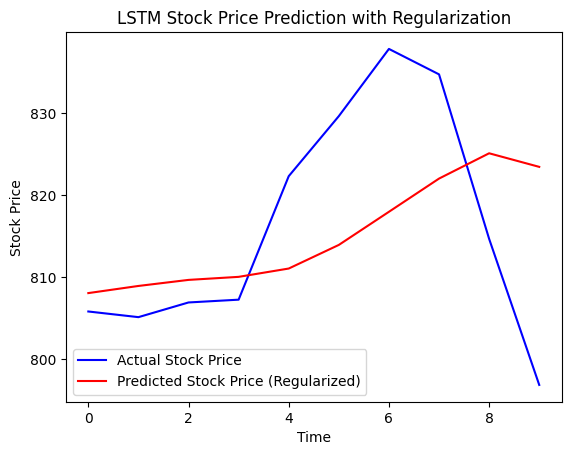

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_reg_inv, color='red', label='Predicted Stock Price (Regularized)')
plt.title('LSTM Stock Price Prediction with Regularization')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# increasing the epochs to 40 and keeping the batch size 16
history_reg = lstm_model_reg.fit(
    X_train_seq, y_train_seq,
    epochs=40,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 0.0047
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0018
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 12/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0

In [ ]:
# Predict on test data
y_test_pred_reg = lstm_model_reg.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_reg_inv = scaler_target.inverse_transform(y_test_pred_reg)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_reg = mean_absolute_error(y_test_actual_inv, y_test_pred_reg_inv)
rmse_reg = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_reg_inv))

print(f"MAE with Regularization: {mae_reg}")
print(f"RMSE with Regularization: {rmse_reg}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
MAE with Regularization: 15.55274584960938
RMSE with Regularization: 19.994308358839138


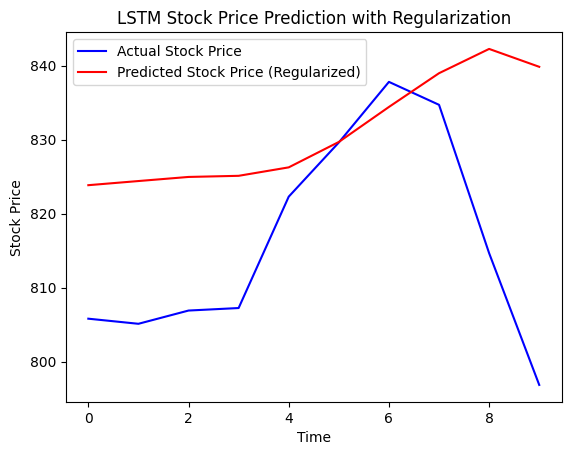

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_reg_inv, color='red', label='Predicted Stock Price (Regularized)')
plt.title('LSTM Stock Price Prediction with Regularization')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 9. GRU architecture

In [ ]:
# GRU model from scratch
# Define the GRU model
def build_gru_model(input_shape):
    model = Sequential()

    # Add GRU layer
    model.add(GRU(
        units=50,
        activation='tanh',
        return_sequences=False,
        input_shape=input_shape,
        recurrent_dropout=0.2  # Optional recurrent dropout for regularization
    ))

    # Add Dropout layer
    model.add(Dropout(0.3))  # Regular dropout for further regularization

    # Add Dense output layer
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Build the GRU model
gru_model = build_gru_model(input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

# Summary of the model
gru_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           8,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,601 (33.60 KB)

 Trainable params: 8,601 (33.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the GRU model
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0969 - val_loss: 0.1117
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0187 - val_loss: 0.0654
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0139 - val_loss: 0.0416
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0104 - val_loss: 0.0294
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0084 - val_loss: 0.0344
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0073 - val_loss: 0.0227
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0070 - val_loss: 0.0173
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0073 - val_loss: 0.0221
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0055 - val_loss: 0.0200
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0052 - val_loss: 0.0147
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0054 - val_loss: 0.0167
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0

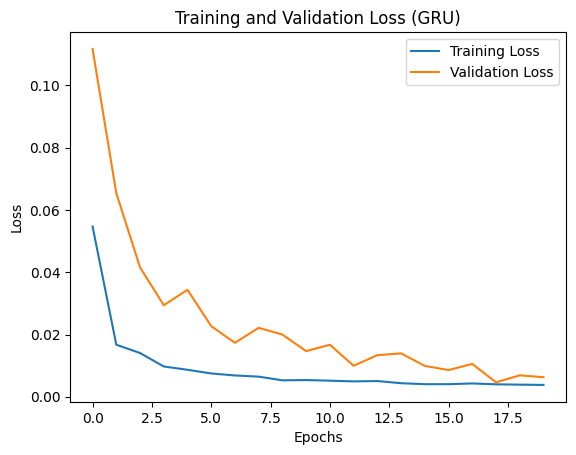

In [ ]:
# Plot training and validation loss
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred_gru = gru_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_gru_inv = scaler_target.inverse_transform(y_test_pred_gru)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_gru = mean_absolute_error(y_test_actual_inv, y_test_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_gru_inv))

print(f"MAE (GRU): {mae_gru}")
print(f"RMSE (GRU): {rmse_gru}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
MAE (GRU): 41.19919555664061
RMSE (GRU): 42.63521924455449


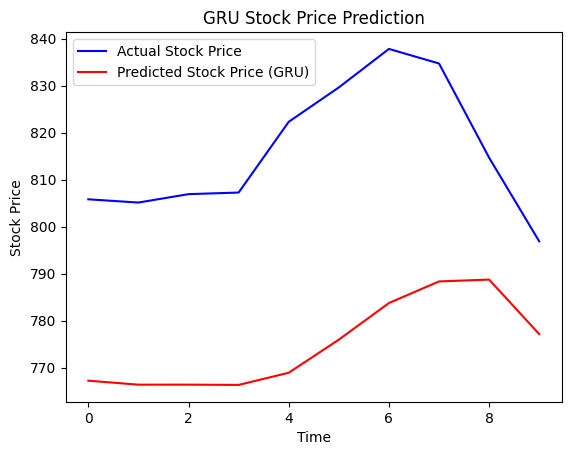

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_gru_inv, color='red', label='Predicted Stock Price (GRU)')
plt.title('GRU Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# 10. Varying epochs and changing the batch size

In [ ]:
# Train the GRU model
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=30,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0042 - val_loss: 0.0097
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0037 - val_loss: 0.0047
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0035 - val_loss: 9.9946e-04
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 9/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 11/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 12/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss:

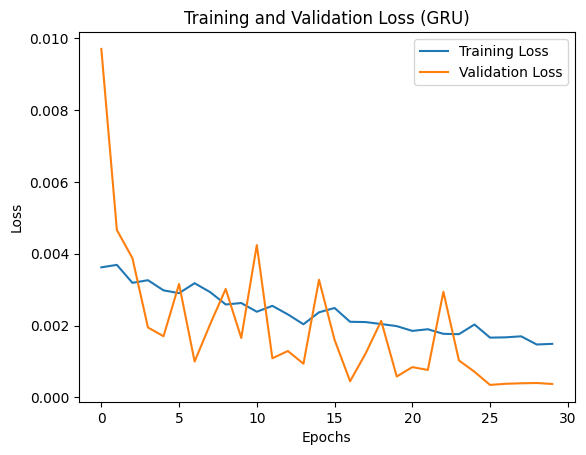

In [ ]:
# Plot training and validation loss
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred_gru = gru_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_gru_inv = scaler_target.inverse_transform(y_test_pred_gru)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_gru = mean_absolute_error(y_test_actual_inv, y_test_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_gru_inv))

print(f"MAE (GRU): {mae_gru}")
print(f"RMSE (GRU): {rmse_gru}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
MAE (GRU): 9.240953613281238
RMSE (GRU): 10.410411340584593


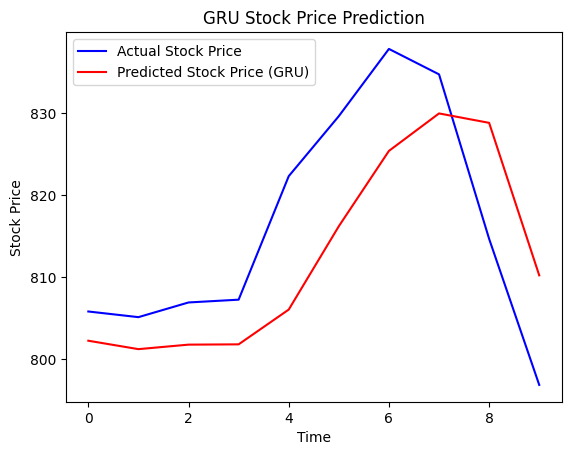

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_gru_inv, color='red', label='Predicted Stock Price (GRU)')
plt.title('GRU Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=40,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0016 - val_loss: 7.6078e-04
Epoch 2/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015 - val_loss: 4.9494e-04
Epoch 3/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 3.2743e-04
Epoch 4/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 3.4696e-04
Epoch 5/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0013 - val_loss: 3.1943e-04
Epoch 6/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0013 - val_loss: 5.5560e-04
Epoch 7/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0015 - val_loss: 3.1684e-04
Epoch 8/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0014 - val_loss: 6.6870e-04
Epoch 9/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 6.0271e-04
Epoch 10/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0015 - val_loss: 4.7436e-04
Epoch 11/40
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0010 - val_loss: 4.6218e-04
Epoch 12/40
63/63 ━

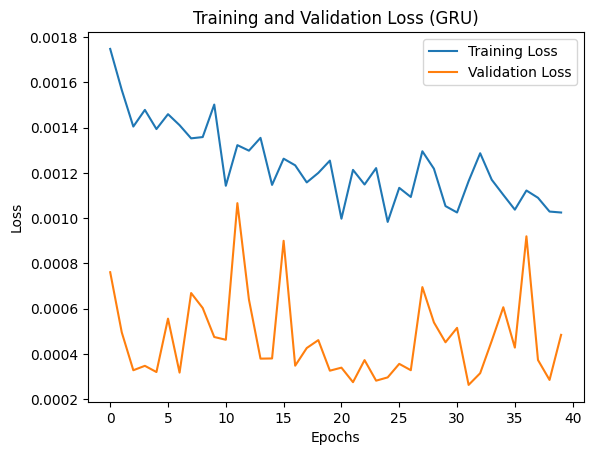

In [ ]:
# Plot training and validation loss
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred_gru = gru_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_gru_inv = scaler_target.inverse_transform(y_test_pred_gru)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_gru = mean_absolute_error(y_test_actual_inv, y_test_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_gru_inv))

print(f"MAE (GRU): {mae_gru}")
print(f"RMSE (GRU): {rmse_gru}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
MAE (GRU): 8.908057861328132
RMSE (GRU): 11.824903251042707


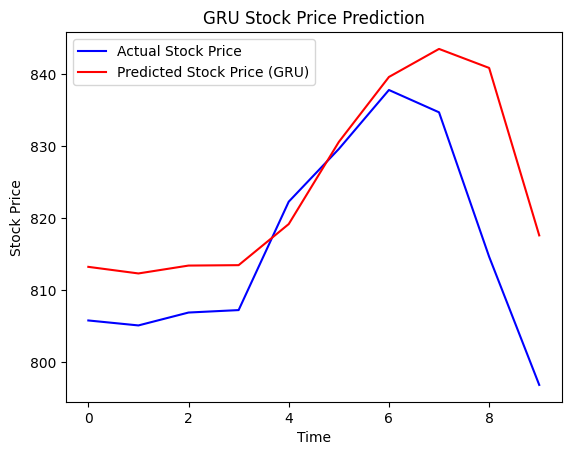

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_gru_inv, color='red', label='Predicted Stock Price (GRU)')
plt.title('GRU Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_seq, y_test_seq),
    verbose=1
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0010 - val_loss: 3.0096e-04
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0010 - val_loss: 2.6054e-04
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0011 - val_loss: 3.2766e-04
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.6829e-04 - val_loss: 0.0013
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0011 - val_loss: 4.2421e-04
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0010 - val_loss: 3.4530e-04
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 9.5924e-04 - val_loss: 4.4800e-04
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0011 - val_loss: 4.5064e-04
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 2.8455e-04
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 9.3441e-04 - val_loss: 2.2928e-04
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 9.9047e-04 - val_loss: 2.7072e-04
Epoch 1

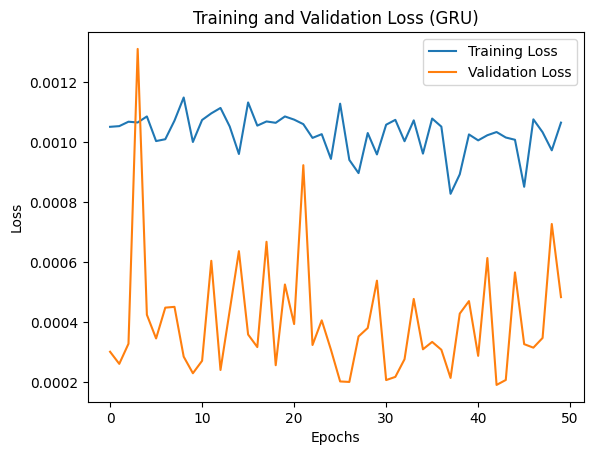

In [ ]:
# Plot training and validation loss
plt.plot(history_gru.history['loss'], label='Training Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (GRU)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Predict on test data
y_test_pred_gru = gru_model.predict(X_test_seq)

# Inverse transform predictions and actual values
y_test_pred_gru_inv = scaler_target.inverse_transform(y_test_pred_gru)
y_test_actual_inv = scaler_target.inverse_transform(y_test_seq)

# Calculate MAE and RMSE
mae_gru = mean_absolute_error(y_test_actual_inv, y_test_pred_gru_inv)
rmse_gru = np.sqrt(mean_squared_error(y_test_actual_inv, y_test_pred_gru_inv))

print(f"MAE (GRU): {mae_gru}")
print(f"RMSE (GRU): {rmse_gru}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
MAE (GRU): 10.766444824218741
RMSE (GRU): 11.814992341217705


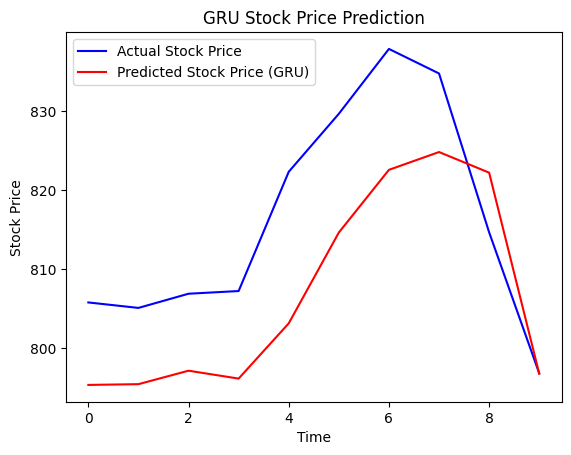

In [ ]:
# Plot actual vs predicted prices
plt.plot(y_test_actual_inv, color='blue', label='Actual Stock Price')
plt.plot(y_test_pred_gru_inv, color='red', label='Predicted Stock Price (GRU)')
plt.title('GRU Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()